In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import gymnasium as gym 
from gymnasium import spaces
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
import matplotlib.pyplot as plt
import glob
import random
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [6]:
SEED = 40

import random
random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

C:\Users\ROG\AppData\Local\Temp\ipykernel_53360\1549329667.py:66: DtypeWarning: Columns (8,16,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv(data_path)



Final aligned data shapes:
  prices: (33131, 5)
  features: (33131, 190)
  first timestamp: 2025-08-04 10:28:00
  last timestamp: 2025-12-03 15:59:00

Train/test split:
  train: 23191 steps from 2025-08-04 10:28:00 to 2025-10-27 14:49:00
  test:  9940 steps from 2025-10-27 14:50:00 to 2025-12-03 15:59:00

>>> Training PPO...
Trained up to step 50000
Training finished.

>>> Backtesting PPO...

STRATEGY BENCHMARK COMPARISON (Including Pairs Trading)
               Total Return Ann Return Sharpe  Max DD
Strategy                                             
PPO_Agent            -2.02%    -18.27%  -3.08  -2.60%
Buy_Hold_Equal       -0.18%     -1.74%  -0.20  -3.03%
Hold_VOO             -0.03%     -0.32%  -0.02  -5.57%
Pairs_Trading         3.54%     41.08%   9.87  -0.57%


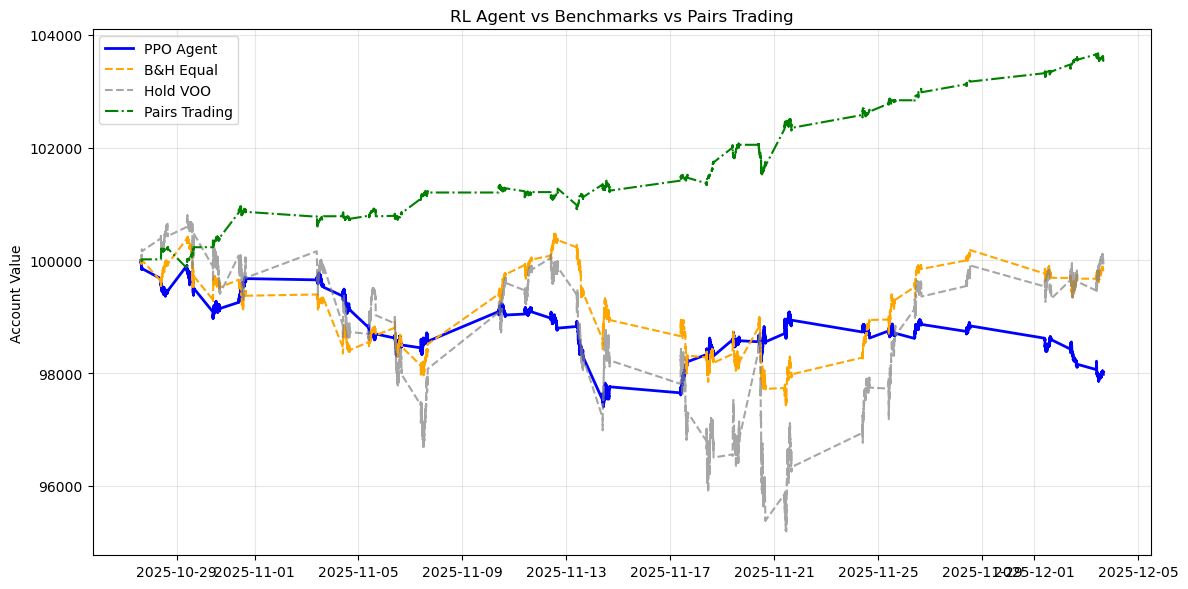


All results saved to ./compare/


<Figure size 640x480 with 0 Axes>

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import random

# ==========================================
# 0. Global Setup & Seeds
# ==========================================
SEED = 40
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ==========================================
# 1. Data Processing
# ==========================================
def build_price_and_features(
    data_path: str = "data.csv",
    vol_path: str = "volatility_forecasts.csv",
    a6_path: str = "A6.csv",
    a101_path: str = "A101.csv",
    factor_dir: str = "factor_outputs",
    tickers=("VOO", "IEMG", "GLDM", "TLT", "HYG"),
):
    def _normalize_index_utc_for_index(x):
        dt = pd.to_datetime(x, utc=True)
        if not isinstance(dt, pd.DatetimeIndex):
            dt = pd.DatetimeIndex(dt)
        return dt.tz_convert(None)

    def _normalize_index_utc_for_series(s: pd.Series) -> pd.Series:
        dt = pd.to_datetime(s, utc=True)
        return dt.dt.tz_convert(None)

    def _read_signal_csv(path, tickers, ref_idx, shift_one=False, prefix=""):
        if not os.path.isfile(path):
            if not os.path.exists(path): 
                return pd.DataFrame(index=ref_idx)
            
        df = pd.read_csv(path, index_col=0)
        df.index = _normalize_index_utc_for_index(df.index)
        df = df.sort_index()

        available_cols = [tic for tic in tickers if tic in df.columns]
        df = df[available_cols]

        if shift_one:
            df = df.shift(1)

        df = df.reindex(ref_idx)
        df.columns = [f"{prefix}_{tic}" for tic in available_cols]
        return df

    if not os.path.exists(data_path):
         raise FileNotFoundError(f"Data file not found: {data_path}")
         
    base_df = pd.read_csv(data_path)
    base_df["DateTime"] = _normalize_index_utc_for_series(base_df["DateTime"])
    base_df = base_df.sort_values("DateTime").set_index("DateTime")

    price_cols = [f"{tic}_Close" for tic in tickers]
    prices_df = pd.DataFrame(index=base_df.index)
    for tic, col in zip(tickers, price_cols):
        if col in base_df.columns:
            prices_df[f"close_{tic}"] = base_df[col]
            
    idx = prices_df.index.copy()

    vol_df = _read_signal_csv(vol_path, tickers, idx, shift_one=False, prefix="vol")
    a6_df = _read_signal_csv(a6_path, tickers, idx, shift_one=True, prefix="a6")
    a101_df = _read_signal_csv(a101_path, tickers, idx, shift_one=True, prefix="a101")

    factor_frames = []
    if os.path.isdir(factor_dir):
        clean_files = glob.glob(os.path.join(factor_dir, "*_clean.csv"))
        for path in clean_files:
            try:
                fname = os.path.basename(path)
                factor_name = fname.replace("_clean.csv", "")
                df_factor = pd.read_csv(path)
                if "DateTime" not in df_factor.columns or "ticker" not in df_factor.columns: 
                    continue
                df_factor["DateTime"] = _normalize_index_utc_for_series(df_factor["DateTime"])
                
                possible_cols = [c for c in df_factor.columns if c not in ["DateTime", "ticker"]]
                if not possible_cols: 
                    continue
                value_col = possible_cols[0]
                
                pivot = df_factor.pivot(index="DateTime", columns="ticker", values=value_col)
                pivot = pivot.reindex(idx)
                pivot = pivot[[tic for tic in tickers if tic in pivot.columns]]
                pivot.columns = [f"{factor_name}_{tic}" for tic in pivot.columns]
                factor_frames.append(pivot)
            except:
                pass

    feat_df = pd.DataFrame(index=idx)
    for block in [vol_df, a6_df, a101_df] + factor_frames:
        if block is not None and not block.empty:
            feat_df = feat_df.join(block, how="left")

    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    feat_df = feat_df.dropna(how='all', axis=1)
    feat_df = feat_df.dropna()
    
    prices_df = prices_df.reindex(feat_df.index)
    
    price_mat = prices_df.to_numpy(dtype=np.float32)
    feature_mat = feat_df.to_numpy(dtype=np.float32)
    feature_names = list(feat_df.columns)
    
    return price_mat, feature_mat, feat_df.index, feature_names

# ==========================================
# 2. Environment
# ==========================================
class MultiAssetTradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, prices, features, initial_cash=100000.0, transaction_cost=0.0, render_mode=None):
        super().__init__()
        self.prices = prices.astype(np.float32)
        self.features = features.astype(np.float32)
        self.T, self.n_assets = self.prices.shape
        self.feature_dim = self.features.shape[1]
        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.render_mode = render_mode

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.n_assets,), dtype=np.float32)
        self.obs_dim = self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self._reset_internal_state()

    def _reset_internal_state(self):
        self.t = 0
        self.positions = np.zeros(self.n_assets, dtype=np.float32)
        self.cash = float(self.initial_cash)
        self.equity = float(self.initial_cash)

    def _get_observation(self):
        features_t = self.features[self.t]
        price_t = self.prices[self.t]
        position_values = self.positions * price_t
        total_equity = self.equity + 1e-8
        position_pct = position_values / total_equity
        cash_pct = np.array([self.cash / total_equity], dtype=np.float32)
        return np.concatenate([features_t, position_pct.astype(np.float32), cash_pct], axis=0).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_internal_state()
        return self._get_observation(), {}

    def step(self, action):
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        price_t = self.prices[self.t]
        price_tp1 = self.prices[self.t + 1] if self.t + 1 < self.T else price_t

        current_position_value = np.sum(self.positions * price_t)
        self.equity = self.cash + current_position_value

        base_scale = self.equity / float(self.n_assets)
        target_values = base_scale * action
        target_positions = np.where(price_t > 0, target_values / price_t, 0.0).astype(np.float32)

        trade_shares = target_positions - self.positions
        trade_values = trade_shares * price_t
        transaction_costs = self.transaction_cost * np.sum(np.abs(trade_values))

        self.cash = self.cash - np.sum(trade_values) - transaction_costs
        self.positions = self.positions + trade_shares

        new_position_value = np.sum(self.positions * price_tp1)
        new_equity = self.cash + new_position_value
        
        reward = (new_equity - self.equity) / (self.equity + 1e-8)
        
        self.equity = new_equity
        self.t += 1
        terminated = self.t >= self.T - 1
        
        info = {"equity": self.equity, "cash": self.cash, "positions": self.positions.copy()}
        return self._get_observation(), float(reward), terminated, False, info


class PolicyValueNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_sizes=(128, 128)):
        super().__init__()
        layers = []
        input_dim = obs_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.base = nn.Sequential(*layers)
        self.mu_head = nn.Linear(input_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value_head = nn.Linear(input_dim, 1)

    def forward(self, x):
        base = self.base(x)
        mu = torch.tanh(self.mu_head(base))
        std = torch.exp(self.log_std)
        value = self.value_head(base).squeeze(-1)
        return mu, std, value

    def get_dist_and_value(self, obs):
        mu, std, value = self.forward(obs)
        dist = Normal(mu, std)
        return dist, value


class PPOAgent:
    def __init__(
        self,
        obs_dim,
        action_dim,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
        vf_coef=0.5,
        ent_coef=0.0,  
        max_grad_norm=0.5,
        device=None,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm
        
        self.net = PolicyValueNet(obs_dim, action_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            dist, value = self.net.get_dist_and_value(obs_t)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(-1)
        action_np = action.squeeze(0).cpu().numpy()
        return np.clip(action_np, -1.0, 1.0), log_prob.item(), value.item()

    def compute_gae(self, rewards, values, dones, last_value):
        """Generalized Advantage Estimation (GAE-Lambda)."""
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_adv = 0.0
        for t in reversed(range(T)):
            mask = 1.0 - float(dones[t])
            delta = rewards[t] + self.gamma * last_value * mask - values[t]
            last_adv = delta + self.gamma * self.lam * mask * last_adv
            adv[t] = last_adv
            last_value = values[t]
        returns = values + adv
        return adv, returns

    def update(self, batch, epochs=10, batch_size=64):
        obs = torch.as_tensor(batch["obs"], dtype=torch.float32, device=self.device)
        actions = torch.as_tensor(batch["actions"], dtype=torch.float32, device=self.device)
        old_log_probs = torch.as_tensor(batch["log_probs"], dtype=torch.float32, device=self.device)
        returns = torch.as_tensor(batch["returns"], dtype=torch.float32, device=self.device)
        advantages = torch.as_tensor(batch["advantages"], dtype=torch.float32, device=self.device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        n = obs.size(0)
        idxs = np.arange(n)

        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, n, batch_size):
                end = start + batch_size
                mb_idx = idxs[start:end]

                mb_obs = obs[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                dist, values = self.net.get_dist_and_value(mb_obs)
                new_log_probs = dist.log_prob(mb_actions).sum(-1)
                entropy = dist.entropy().sum(-1).mean()

                ratio = torch.exp(new_log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = nn.functional.mse_loss(values, mb_returns)

                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


def train_ppo_on_env(env, agent, total_steps=50000, rollout_horizon=512):
    obs, info = env.reset()
    step_count = 0
    
    while step_count < total_steps:
        obs_buf, act_buf, logp_buf, rew_buf, val_buf, done_buf = [], [], [], [], [], []
        
        for _ in range(rollout_horizon):
            action, logp, value = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            obs_buf.append(obs)
            act_buf.append(action)
            logp_buf.append(logp)
            rew_buf.append(reward)
            val_buf.append(value)
            done_buf.append(done)

            obs = next_obs
            step_count += 1

            if done:
                obs, info = env.reset()

            if step_count >= total_steps:
                break

        if not obs_buf:
            break

        # 使用 compute_gae 方法
        with torch.no_grad():
            last_value = agent.net.get_dist_and_value(
                torch.as_tensor(obs, dtype=torch.float32, device=agent.device).unsqueeze(0)
            )[1].item()

        obs_arr = np.array(obs_buf, dtype=np.float32)
        act_arr = np.array(act_buf, dtype=np.float32)
        logp_arr = np.array(logp_buf, dtype=np.float32)
        rew_arr = np.array(rew_buf, dtype=np.float32)
        val_arr = np.array(val_buf, dtype=np.float32)
        done_arr = np.array(done_buf, dtype=bool)

        adv, ret = agent.compute_gae(rew_arr, val_arr, done_arr, last_value)

        batch = {
            "obs": obs_arr,
            "actions": act_arr,
            "log_probs": logp_arr,
            "returns": ret,
            "advantages": adv,
        }

        agent.update(batch)
        
        if step_count % 5000 == 0:
            print(f"Trained up to step {step_count}")

    print("Training finished.")


def backtest_on_env(env, agent, index):
    obs, info = env.reset()
    equities = [env.initial_cash]
    done = False
    
    while not done:
        a, _, _ = agent.act(obs)
        obs, _, term, trunc, info = env.step(a)
        equities.append(info['equity'])
        done = term or trunc
    
    min_len = min(len(index), len(equities))
    df = pd.DataFrame({"account_value": equities[:min_len]}, index=index[:min_len])
    return df


# ==========================================
# 4. Benchmarking & Comparison Logic
# ==========================================
def run_pairs_trading_strategy(prices, idx_a=0, idx_b=1, window=60, threshold=2.0, initial_cash=100000.0):
    price_a = prices[:, idx_a]
    price_b = prices[:, idx_b]
    
    price_b = np.where(price_b == 0, 1e-8, price_b)
    
    ratio = price_a / price_b
    s_ratio = pd.Series(ratio)
    z_score = (s_ratio - s_ratio.rolling(window).mean()) / (s_ratio.rolling(window).std() + 1e-8)
    z = z_score.fillna(0).to_numpy()
    
    signals = np.zeros_like(z)
    curr_sig = 0
    for t in range(len(z)):
        if z[t] > threshold: 
            curr_sig = -1
        elif z[t] < -threshold: 
            curr_sig = 1
        elif abs(z[t]) < 0.5: 
            curr_sig = 0
        signals[t] = curr_sig
    
    signals = np.roll(signals, 1)
    signals[0] = 0 
    
    ret_a = np.diff(price_a, prepend=price_a[0]) / (price_a + 1e-8)
    ret_b = np.diff(price_b, prepend=price_b[0]) / (price_b + 1e-8)
    
    strat_ret = 0.5 * signals * (ret_a - ret_b)
    
    equity = np.zeros_like(strat_ret)
    equity[0] = initial_cash
    curr_eq = initial_cash
    for t in range(1, len(strat_ret)):
        curr_eq *= (1 + strat_ret[t])
        equity[t] = curr_eq
        
    return equity


def calculate_perf_stats(equity_curve, freq_per_year=252*390):
    if len(equity_curve) < 2: 
        return {}
    equity_curve = pd.Series(equity_curve)
    returns = equity_curve.pct_change().fillna(0.0)
    total_ret = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1.0
    
    n_steps = len(equity_curve)
    ann_ret = (1.0 + total_ret) ** (freq_per_year / n_steps) - 1.0
    ann_vol = returns.std() * np.sqrt(freq_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0.0
    
    cummax = equity_curve.cummax()
    dd = equity_curve / cummax - 1.0
    max_dd = dd.min()
    
    return {
        "Total Return": f"{total_ret:.2%}",
        "Ann Return": f"{ann_ret:.2%}",
        "Sharpe": f"{sharpe:.2f}",
        "Max DD": f"{max_dd:.2%}"
    }


def run_benchmark_comparison(ppo_df, prices_test, test_index, initial_cash=100000.0, tickers=None):
    print("\n" + "="*50)
    print("STRATEGY BENCHMARK COMPARISON (Including Pairs Trading)")
    print("="*50)

    min_len = min(len(ppo_df), len(prices_test))
    df_compare = pd.DataFrame(index=test_index[:min_len])
    prices_test = prices_test[:min_len]
    
    df_compare['PPO_Agent'] = ppo_df['account_value'].iloc[:min_len].values

    norm_prices = prices_test / prices_test[0]
    df_compare['Buy_Hold_Equal'] = np.mean(norm_prices, axis=1) * initial_cash

    try:
        voo_idx = tickers.index("VOO")
    except:
        voo_idx = 0
    df_compare['Hold_VOO'] = norm_prices[:, voo_idx] * initial_cash

    pair_equity = run_pairs_trading_strategy(
        prices_test, idx_a=0, idx_b=1, 
        initial_cash=initial_cash
    )
    df_compare['Pairs_Trading'] = pair_equity[:min_len]

    stats_list = []
    for col in df_compare.columns:
        stats = calculate_perf_stats(df_compare[col], freq_per_year=252*390)
        stats['Strategy'] = col
        stats_list.append(stats)
    
    print(pd.DataFrame(stats_list).set_index('Strategy'))

    plt.figure(figsize=(12, 6))
    plt.plot(df_compare.index, df_compare['PPO_Agent'], label='PPO Agent', linewidth=2, color='blue')
    plt.plot(df_compare.index, df_compare['Buy_Hold_Equal'], label='B&H Equal', linestyle='--', color='orange')
    plt.plot(df_compare.index, df_compare['Hold_VOO'], label='Hold VOO', linestyle='--', color='gray', alpha=0.7)
    plt.plot(df_compare.index, df_compare['Pairs_Trading'], label='Pairs Trading', linestyle='-.', color='green')
    
    plt.title("RL Agent vs Benchmarks vs Pairs Trading")
    plt.ylabel("Account Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("benchmark_comparison.png", dpi=150)
    plt.show()
    
    os.makedirs("compare", exist_ok=True)
 
    df_compare.to_csv("compare/all_strategies_equity.csv")
    
    for col in df_compare.columns:
        df_compare[[col]].to_csv(f"compare/{col}_equity.csv")
    
    stats_df = pd.DataFrame(stats_list).set_index('Strategy')
    stats_df.to_csv("compare/performance_stats.csv")
    
    plt.savefig("compare/benchmark_comparison.png", dpi=150)
    
    print("\nAll results saved to ./compare/")
    
    return df_compare


# ==========================================
# 5. Main Execution
# ==========================================
if __name__ == "__main__":
    TICKERS = ("VOO", "IEMG", "GLDM", "TLT", "HYG")
    
    try:
        prices, features, idx, feat_names = build_price_and_features(
            data_path="../data.csv",
            vol_path="../volatility_forecasts.csv",
            a6_path="../A6.csv",
            a101_path="../A101.csv",
            factor_dir="../OHLC/factor_outputs",
            tickers=TICKERS,
        )
        
        print("\nFinal aligned data shapes:")
        print("  prices:", prices.shape)
        print("  features:", features.shape)
        print("  first timestamp:", idx[0])
        print("  last timestamp:", idx[-1])
        
        # Train/Test Split
        split_idx = int(len(prices) * 0.7)
        prices_train, prices_test = prices[:split_idx], prices[split_idx:]
        features_train, features_test = features[:split_idx], features[split_idx:]
        idx_train, idx_test = idx[:split_idx], idx[split_idx:]
        
        print(f"\nTrain/test split:")
        print(f"  train: {len(idx_train)} steps from {idx_train[0]} to {idx_train[-1]}")
        print(f"  test:  {len(idx_test)} steps from {idx_test[0]} to {idx_test[-1]}")
        
        # Build Envs (transaction_cost=0.0 by default now)
        env_train = MultiAssetTradingEnv(prices_train, features_train)
        env_test = MultiAssetTradingEnv(prices_test, features_test)
        
        # Train (ent_coef=0.0 by default now)
        agent = PPOAgent(env_train.obs_dim, env_train.n_assets, lr=3e-4)
        print("\n>>> Training PPO...")
        train_ppo_on_env(env_train, agent, total_steps=50000)
        
        # Backtest PPO
        print("\n>>> Backtesting PPO...")
        df_ppo = backtest_on_env(env_test, agent, idx_test)
        
        # Compare Everything
        df_compare = run_benchmark_comparison(
            df_ppo, 
            prices_test, 
            idx_test, 
            initial_cash=100000.0, 
            tickers=TICKERS
        )
        
        
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        import traceback
        traceback.print_exc()